In [1]:
# 导入程序所需要的程序包

import json

#PyTorch-packages
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# packages of NLP
import re 
from collections import Counter #搜集器，可以让统计词频更简单
import pandas as pd
import jieba



#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#  Data process

### 1. load original dataset & split correct/incorrect-label dataset

Data formulation:
<code>bug-id $$ bug report text $$ bug report description $$ generated patch id $$ patch text $$ label</code>

In [2]:
# remove numbers and '-'
def numbr(string):
    newstring = ''.join([i for i in string if not i.isdigit()])
    newstring = newstring.replace('-','')
    return newstring
# remove punctuation
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）)：]+", " ", sentence)  
    return(sentence)

In [4]:
import io
bugreportcommitfile = open('./data/bugreport_patch.txt')
lines = bugreportcommitfile.readlines()
print(len(lines))

column_names = ['bug_id', 'bug report text', 'bug report description', 'generated patch id', 'patch text', 'label']
# create a dataframe to store cleaned data
df = pd.DataFrame(columns = column_names)


for line in lines:
    line2list = line.split('$$')
    line2list[-1] = line2list[-1].replace('\n','')
    #print(line2list)
    line2list[0] = numbr(line2list[0])
    
    #for bug report text
    line2list[1] = filter_punc(line2list[1])
    
    #for bug report description
    line2list[2] = filter_punc(line2list[2])
    
    #for generated patch id
    line2list[3] = numbr(line2list[2])    
    
    #for patch text
    line2list[4] = filter_punc(line2list[3])
    
    # add data into df file
    df_toadd = pd.DataFrame([line2list], columns = column_names)
    df = df.append(df_toadd)
    

9181


In [5]:
df.head()

,bug_id,bug report text,bug report description,generated patch id,patch text,label
0,Math,ListPopulation Iterator allows you to remove c...,Calling the iterator method of ListPopulation ...,Calling the iterator method of ListPopulation ...,Calling the iterator method of ListPopulation ...,1
0,Math,BisectionSolver solve final UnivariateRealFunc...,Method BisectionSolver solve final UnivariateR...,Method BisectionSolver solve final UnivariateR...,Method BisectionSolver solve final UnivariateR...,1
0,Math,Complex ZERO reciprocal returns NaN but shou...,Complex ZERO reciprocal returns NaN but shou...,Complex ZERO reciprocal returns NaN but shou...,Complex ZERO reciprocal returns NaN but should...,1
0,Math,Fix and then deprecate isSupportXxxInclusive i...,The conclusion from [1] was never implemented ...,The conclusion from [] was never implemented W...,The conclusion from [] was never implemented W...,1
0,Time,Inconsistent interpretation of ambiguous time ...,The inconsistency appears for timezone Europe ...,The inconsistency appears for timezone Europe ...,The inconsistency appears for timezone Europe ...,1


In [6]:
df.to_csv('./data/bugreport_patch.csv')

**Data pre-analysis**

**1-Distribution for catalogy**

In [7]:
class_names = list(Counter(list(df.iloc[:,0].values)).keys())
class_numbers = np.array(list(Counter(list(df.iloc[:,0].values)).values()))
print(class_names)
print(class_numbers)

['Math', 'Time', 'Lang', 'Closure', 'Chart', 'Mockito', 'OAKfeadc', 'MATHcb', 'MATHeed', 'OAKcbe', 'MATHccd', 'OAKd', 'MATHedcd', 'MATHdd', 'Bears']
[3741   76 1347  326  494   46  768  128  618    8    5  686  789   66
   83]


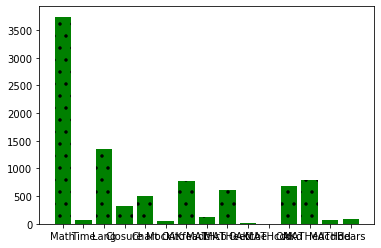

In [8]:
# plot
plt.bar(range(len(class_names)), class_numbers, color='g',tick_label=class_names, hatch = '.')
plt.show()

**2-Distribution for Effectiveness**

In [9]:
class_names = ['None', 'Others']
class_numbers = []
for counter in sorted(Counter(Counter(Counter(list(df.iloc[:,1].values)))).most_common(1), key=lambda x: x[0]): class_numbers.append(counter[1])
Others_num = len(lines)-counter[1]
class_numbers.append(Others_num)

print(class_numbers)

[1032, 8149]


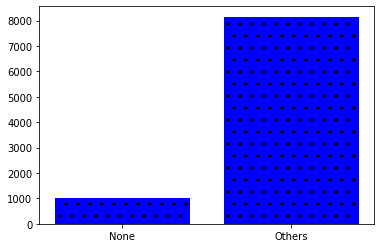

In [10]:
# plot
plt.bar(range(len(class_names)), class_numbers, color='b',tick_label=class_names, hatch = '.')
plt.show()

**Split dataset into correct&incorrect.txt**

In [11]:
list_type = df['label'].unique()
print(list_type)

['1' '0']


In [12]:
df_0 = df[df['label'].isin([list_type[0]])]
df_1 = df[df['label'].isin([list_type[1]])]

In [13]:
# store correct.csv & incorrect.csv into path './data/'
df_0.to_csv('./data/correct.csv')
df_1.to_csv('./data/incorrect.csv')

In [14]:
# Only take bug report and generated patch into consideration, and generate correct.txt and incorrect.txt
correct_file = open('./data/correct.txt', 'w')
for i in range(df_0.shape[0]):
    correct_text2add = df_0.iloc[i,1] + ' ST '+ df_0.iloc[i,3] + '\n'
    correct_file.write(correct_text2add)
correct_file.close()

incorrect_file = open('./data/incorrect.txt', 'w')
for i in range(df_1.shape[0]):
    incorrect_text2add = df_1.iloc[i,1] + ' ST '+ df_1.iloc[i,3] + '\n'
    incorrect_file.write(incorrect_text2add)
correct_file.close()

#&# 2.数据预处理

In [15]:
# 数据来源文件
correct_file = 'data/correct.txt'
incorrect_file  = 'data/incorrect.txt'



#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(correct_file, incorrect_file, is_filter = True):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储correct的 pair
    neg_sentences = [] #存储incorrect的pair
    with open(correct_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(correct_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(incorrect_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(incorrect_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(correct_file, incorrect_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
st


Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.899 seconds.
Prefix dict has been built successfully.


data/correct.txt 包含 1637 行, 284930 个词.
data/incorrect.txt 包含 7544 行, 1826017 个词.
字典大小：4577


[(1, '00FFFF'),
 (1, '03'),
 (1, '1087'),
 (1, '1115'),
 (1, '1139'),
 (1, '1152'),
 (1, '1173'),
 (1, '1175'),
 (1, '1196'),
 (1, '1201'),
 (1, '1215'),
 (1, '1422'),
 (1, '16'),
 (1, '1BC'),
 (1, '201'),
 (1, '20110811'),
 (1, '2017'),
 (1, '29'),
 (1, '563'),
 (1, '658'),
 (1, '7525'),
 (1, '776'),
 (1, '80'),
 (1, '928'),
 (1, '957'),
 (1, '972'),
 (1, 'ARRAY'),
 (1, 'AS'),
 (1, 'AST'),
 (1, 'Actually'),
 (1, 'Adak'),
 (1, 'AddressVDeserializer'),
 (1, 'Again'),
 (1, 'AllArgsConstructor'),
 (1, 'Alpha'),
 (1, 'Alternatively'),
 (1, 'Always'),
 (1, 'Am'),
 (1, 'Angeles'),
 (1, 'Another'),
 (1, 'Anton'),
 (1, 'Application'),
 (1, 'Are'),
 (1, 'Argument'),
 (1, 'ArithmeticException'),
 (1, 'ArrayOutOfBounds'),
 (1, 'ArrayStoreException'),
 (1, 'Asia'),
 (1, 'Assignments'),
 (1, 'Assume'),
 (1, 'Atka'),
 (1, 'Automated'),
 (1, 'B'),
 (1, 'BA'),
 (1, 'BC'),
 (1, 'BOBYQA'),
 (1, 'BaseClass'),
 (1, 'BasicDeserializerFactory'),
 (1, 'Basically'),
 (1, 'Be'),
 (1, 'BeanSerializerBase'),
 (1

## tokenization and initial embedding


### 1. Training data

In [16]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

##  Evaluation Method

In [17]:
def evaluation_metrics(self, y_trues, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true=y_trues, y_score=y_pred_probs, pos_label=1)
    auc_ = auc(fpr, tpr)

    y_preds = [1 if p >= 0.5 else 0 for p in y_pred_probs]

    acc = accuracy_score(y_true=y_trues, y_pred=y_preds)
    prc = precision_score(y_true=y_trues, y_pred=y_preds)
    rc = recall_score(y_true=y_trues, y_pred=y_preds)
    f1 = 2 * prc * rc / (prc + rc)

    print('\n***------------***')
    print('Evaluating AUC, F1, +Recall, -Recall')
    print('Test data size: {}, Incorrect: {}, Correct: {}'.format(len(y_trues), y_trues.count(0), y_trues.count(1)))
    print('Accuracy: %f -- Precision: %f -- +Recall: %f -- F1: %f ' % (acc, prc, rc, f1))
    tn, fp, fn, tp = confusion_matrix(y_trues, y_preds).ravel()
    recall_p = tp / (tp + fn)
    recall_n = tn / (tn + fp)
    print('AUC: {:.3f}, +Recall: {:.3f}, -Recall: {:.3f}'.format(auc_, recall_p, recall_n))
    # return , auc_

    # print('AP: {}'.format(average_precision_score(y_trues, y_pred_probs)))
    return recall_p, recall_n, acc, prc, rc, f1, auc_

### 2. model defination

In [18]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

### 3. model training

In [19]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

/home/daniel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


第0轮，训练损失：0.64, 校验损失：0.65, 校验准确率: 0.82
第0轮，训练损失：0.22, 校验损失：0.16, 校验准确率: 0.92
第0轮，训练损失：0.18, 校验损失：0.17, 校验准确率: 0.93
第1轮，训练损失：0.18, 校验损失：0.14, 校验准确率: 0.95
第1轮，训练损失：0.16, 校验损失：0.13, 校验准确率: 0.96
第1轮，训练损失：0.15, 校验损失：0.17, 校验准确率: 0.95
第2轮，训练损失：0.15, 校验损失：0.13, 校验准确率: 0.95
第2轮，训练损失：0.15, 校验损失：0.14, 校验准确率: 0.95
第2轮，训练损失：0.14, 校验损失：0.17, 校验准确率: 0.95
第3轮，训练损失：0.14, 校验损失：0.14, 校验准确率: 0.95
第3轮，训练损失：0.14, 校验损失：0.14, 校验准确率: 0.95
第3轮，训练损失：0.13, 校验损失：0.17, 校验准确率: 0.95
第4轮，训练损失：0.13, 校验损失：0.14, 校验准确率: 0.95
第4轮，训练损失：0.13, 校验损失：0.15, 校验准确率: 0.95
第4轮，训练损失：0.13, 校验损失：0.18, 校验准确率: 0.95
第5轮，训练损失：0.13, 校验损失：0.15, 校验准确率: 0.95
第5轮，训练损失：0.13, 校验损失：0.15, 校验准确率: 0.95
第5轮，训练损失：0.12, 校验损失：0.18, 校验准确率: 0.95
第6轮，训练损失：0.12, 校验损失：0.15, 校验准确率: 0.95
第6轮，训练损失：0.12, 校验损失：0.16, 校验准确率: 0.95
第6轮，训练损失：0.12, 校验损失：0.18, 校验准确率: 0.95
第7轮，训练损失：0.12, 校验损失：0.15, 校验准确率: 0.96
第7轮，训练损失：0.12, 校验损失：0.16, 校验准确率: 0.95
第7轮，训练损失：0.12, 校验损失：0.19, 校验准确率: 0.95
第8轮，训练损失：0.12, 校验损失：0.15, 校验准确率: 0.96
第8轮，训练损失：0.12, 校验损失：0.16, 校验准确率: 0.95
第8轮，训练损失：0.1

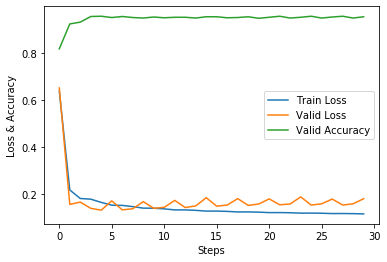

In [20]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [21]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/home/daniel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9564270152505446

### 4. network analysis

#### 1). check each layer

In [22]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=4577, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=None)
)>

Text(0, 0.5, 'Weights')

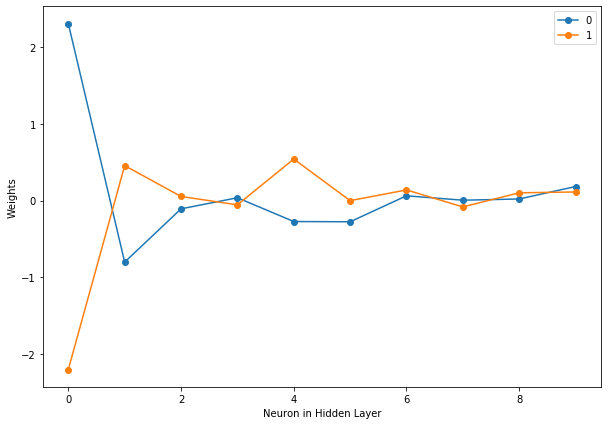

In [23]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

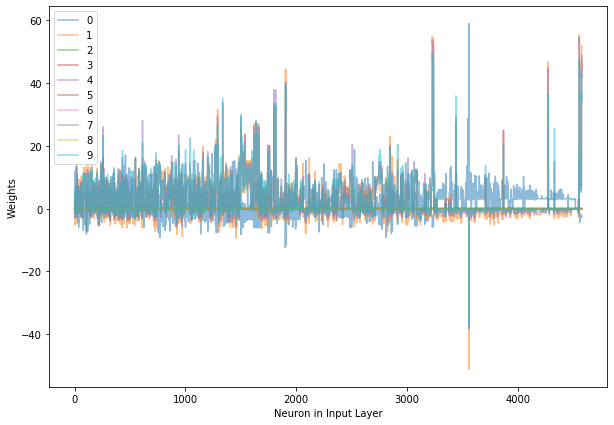

In [24]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [25]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)




第0个神经元
max:
noformat
nodes
levels
zone
whenever
higher
stays
jumps
faulty
PropertyIndex
traversal
adding
level
instance
content
gets
getPct
getCumPct
Frequency
min:
inverseCumulativeProbability
checkedCumulativeProbability
BinomialDistribution
BinomialDistributionImpl
trials
suppose
NumberFormatException
decomposition
R
trunk
location
round
nonzero
sample
Pair
DiscreteDistribution
sampleSize
singletons
newInstance
Attaching


第1个神经元
max:
Precision
DurationFormatUtils
MONTH
UP
usage
ROUND
MILLISECOND
Dec
formatPeriod
getTimeInMillis
YEAR
MM
DECEMBER
oddly
currentTimeMillis
SECOND
LevenburgMaquardt
switched
trash
min:
noformat
runtime
something
MAX
RealMatrixImpl
dimensions
operate
nRows
nonsquare
row
Thus
summary
possibly
toClass
code
takes
implements
missing
now
failures


第2个神经元
max:
Incomplete
QueryExecutionConverters
UnivariateRealSolverImpl
ObjectInputStream
INFINITY
CC
hearing
developer
threed
daysBetween
verify
Valid
NormalDistribution
checkVectorDimensions
jacksonrecursivetype

#### 2. Searching for potential error reasons

In [26]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

/home/daniel/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [27]:
sentences[178+178] # 错误的地方

['Incorrect',
 ' ',
 'rounding',
 ' ',
 'of',
 ' ',
 'float',
 ' ',
 'ST',
 ' ',
 'package',
 ' ',
 'org',
 ' ',
 'apache',
 ' ',
 'commons',
 ' ',
 'math',
 ' ',
 'util',
 ' ',
 'example',
 ' ',
 'of',
 ' ',
 'usage',
 ' ',
 'of',
 ' ',
 'round',
 ' ',
 'functions',
 ' ',
 'of',
 ' ',
 'Precision',
 ' ',
 'class',
 ':',
 ' ',
 'Precision',
 ' ',
 'round',
 ' ',
 'f',
 ' ',
 'BigDecimal',
 ' ',
 'ROUND',
 ' ',
 'UP',
 ' ',
 '=',
 ' ',
 'Precision',
 ' ',
 'round',
 ' ',
 'float',
 ' ',
 'BigDecimal',
 ' ',
 'ROUND',
 ' ',
 'UP',
 ' ',
 '=',
 ' ',
 'Precision',
 ' ',
 'round',
 ' ',
 'float',
 ' ',
 '=',
 ' ',
 'Precision',
 ' ',
 'round',
 ' ',
 'BigDecimal',
 ' ',
 'ROUND',
 ' ',
 'UP',
 ' ',
 '=',
 ' ',
 'Seems',
 ' ',
 'the',
 ' ',
 'reason',
 ' ',
 'is',
 ' ',
 'usage',
 ' ',
 'of',
 ' ',
 'extending',
 ' ',
 'float',
 ' ',
 'to',
 ' ',
 'double',
 ' ',
 'inside',
 ' ',
 'round',
 ' ',
 'functions',
 ' ',
 'and',
 ' ',
 'getting',
 ' ',
 'influence',
 ' ',
 'of',
 ' ',
 'memory',
 

In [28]:
test_data

[array([0.        , 0.48965517, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0.  , 0.5 , 0.  , ..., 0.02, 0.  , 0.  ]),
 array([0.        , 0.49282297, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0.  , 0.5 , 0.  , ..., 0.02, 0.  , 0.  ]),
 array([0.        , 0.45622896, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0. , 0.5, 0. , ..., 0. , 0. , 0. ]),
 array([0.        , 0.48920863, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0. , 0.5, 0. , ..., 0. , 0. , 0. ]),
 array([0.        , 0.5       , 0.        , ..., 0.        , 0.07142857,
        0.07142857]),
 array([0.        , 0.49681529, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0. , 0.5, 0. , ..., 0. , 0. , 0. ]),
 array([0.        , 0.49677419, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0.  , 0.5 , 0.  , ..., 0.02, 0.  , 0.  ]),
 array([0. , 0.5, 0. , ..., 0. , 0. , 0. ]),
 a

In [29]:
# 逐个查看出错的句子是什么
idx = 1
print(sentences[sent_indices[idx]], targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

['IllegalStateException', ' ', 'at', ' ', 'com', ' ', 'google', ' ', 'javascript', ' ', 'rhino', ' ', 'jstype', ' ', 'FunctionType', ' ', 'getInstanceType', ' ', 'ST', ' ', 'None', ' '] 0
[' ', 'ST', 'None', 'at', 'javascript', 'com', 'google', 'IllegalStateException', 'rhino', 'jstype', 'FunctionType', 'getInstanceType']


In [30]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[ 0.0853407 ],
       [-0.31912179],
       [-0.0028213 ],
       [-0.03042497],
       [-0.81533769],
       [-0.00180128],
       [-0.04251227],
       [ 0.00668549],
       [-0.04161284],
       [-0.63137839]])

## RNN

In [31]:
# 需要重新数据预处理，主要是要加上标点符号，它对于RNN起到重要作用
# 数据来源文件
good_file = 'data/correct.txt'
bad_file  = 'data/incorrect.txt'
# 生成正样例和反样例，以及词典，很有趣的是，词典中的词语竟然比不考虑标点符号的时候少了（要知道标点也是被当作一个单词的），
# 主要原因应该是总的分词出来的数量变少了。当去掉标点符号以后，有很多字的组合被当作了单词处理了。
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, False)

data/correct.txt 包含 1637 行, 305631 个词.
data/incorrect.txt 包含 7544 行, 2161070 个词.
字典大小：4578


In [32]:
# 重新准备数据，输入给RNN
# 与词袋模型不同的是。每一个句子在词袋模型中都被表示为了固定长度的向量，其中长度为字典的尺寸
# 在RNN中，每一个句子就是被单独当成词语的序列来处理的，因此序列的长度是与句子等长的

dataset = []
labels = []
sentences = []

# 正例集合
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            # 注意将每个词编码
            new_sentence.append(word2index(l, diction))
    #每一个句子都是一个不等长的整数序列
    dataset.append(new_sentence)
    labels.append(0)
    sentences.append(sentence)

# 反例集合
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(new_sentence)
    labels.append(1)
    sentences.append(sentence)

# 重新对数据洗牌，构造数据集合
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

# 校验集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]

# 测试集
test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


In [34]:
# 一个手动实现的RNN模型

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # 一个embedding层
        self.embed = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.i2h = nn.Linear(2 * hidden_size, hidden_size)
        # 隐含层到输出层的链接
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        
        # 先进行embedding层的计算，它可以把一个数或者数列，映射成一个向量或一组向量
        # input尺寸：seq_length, 1
        x = self.embed(input)
        # x尺寸：hidden_size
        
        # 将输入和隐含层的输出（hidden）耦合在一起构成了后续的输入
        combined = torch.cat((x, hidden), 1)
        # combined尺寸：2*hidden_size
        #
        # 从输入到隐含层的计算
        hidden = self.i2h(combined)
        # combined尺寸：hidden_size
        
        # 从隐含层到输出层的运算
        output = self.i2o(hidden)
        # output尺寸：output_size
        
        # softmax函数
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是：batch_size, hidden_size
        return torch.zeros(1, self.hidden_size)



In [ ]:
# 开始训练这个RNN，10个隐含层单元
rnn = RNN(len(diction), 10, 2)

# 交叉熵评价函数
cost = torch.nn.NLLLoss()

# Adam优化器
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.001)
records = []

# 学习周期10次
losses = []
for epoch in range(10):
    
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
        #x尺寸：seq_length（序列的长度）
        y = torch.tensor(np.array([y]), dtype = torch.long)
        #x尺寸：batch_size = 1,1
        optimizer.zero_grad()
        
        #初始化隐含层单元全为0
        hidden = rnn.initHidden()
        # hidden尺寸：batch_size = 1, hidden_size
        
        #手动实现RNN的时间步循环，x的长度就是总的循环时间步，因为要把x中的输入句子全部读取完毕
        for s in range(x.size()[0]):
            output, hidden = rnn(x[s], hidden)
        
        #校验函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        loss.backward()
        # 开始优化
        optimizer.step()
        if i % 3000 == 0:
            # 每间隔3000步来一次校验集上面的计算
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                hidden = rnn.initHidden()
                for s in range(x.size()[0]):
                    output, hidden = rnn(x[s], hidden)
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            # 计算准确度
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


第0轮，训练损失：0.89, 测试损失：0.60, 测试准确率: 0.81
第0轮，训练损失：0.27, 测试损失：0.21, 测试准确率: 0.89
第0轮，训练损失：0.23, 测试损失：0.20, 测试准确率: 0.90
第1轮，训练损失：0.22, 测试损失：0.19, 测试准确率: 0.92
第1轮，训练损失：0.20, 测试损失：0.18, 测试准确率: 0.93
第1轮，训练损失：0.19, 测试损失：0.18, 测试准确率: 0.91
第2轮，训练损失：0.19, 测试损失：0.17, 测试准确率: 0.93
第2轮，训练损失：0.18, 测试损失：0.17, 测试准确率: 0.93


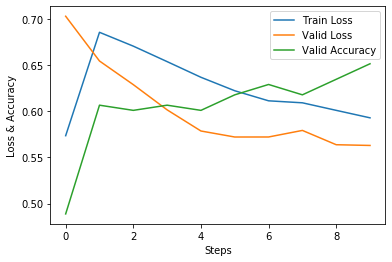

In [34]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [35]:
#在测试集上运行，并计算准确率
vals = [] #记录准确率所用列表
rights = []
#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = rnn.initHidden()
    for s in range(x.size()[0]):
        output, hidden = rnn(x[s], hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6292134831460674

## LSTM

In [28]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：一个embedding层，将输入的任意一个单词映射为一个向量
        # 一个LSTM隐含层，共有hidden_size个LSTM神经元
        # 一个全链接层，外接一个softmax输出
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, 2)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        
        #input尺寸: seq_length
        #词向量嵌入
        embedded = self.embedding(input)
        #embedded尺寸: seq_length, hidden_size
        
        #PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        #第二个维度才是batch_size，所以需要对embedded变形
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
       
        #embedded尺寸: seq_length, batch_size = 1, hidden_size
    
        #调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm(embedded, hidden)
        
        
        #output尺寸: seq_length, batch_size = 1, hidden_size
        #hidden尺寸: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]
        #output尺寸: batch_size = 1, hidden_size

        #全链接层
        out = self.fc(output)
        #out尺寸: batch_size = 1, output_size
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        
        # 对隐单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return (hidden, cell)



In [ ]:
# 开始训练LSTM网络

# 构造一个LSTM网络的实例
lstm = LSTMNetwork(len(diction), 10, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 开始训练，一共5个epoch，否则容易过拟合
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.LongTensor(x).unsqueeze(1)
        #x尺寸：seq_length，序列的长度
        y = torch.LongTensor([y])
        #y尺寸：batch_size = 1, 1
        optimizer.zero_grad()
        
        #初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        #hidden: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        #它自动会根据数据的维度计算若干时间步
        
        output = lstm(x, hidden)
        #output尺寸: batch_size = 1, output_size
        
        #损失函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.LongTensor(x).unsqueeze(1)
                y = torch.LongTensor(np.array([y]))
                hidden = lstm.initHidden()
                output = lstm(x, hidden)
                #计算校验数据集上的分类准确度
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


第0轮，训练损失：0.68, 测试损失：0.69, 测试准确率: 0.48


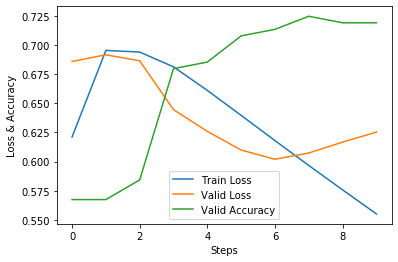

In [37]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [38]:
#在测试集上计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = lstm.initHidden()
    output = lstm(x, hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6123595505617978

## BiLSTM网络,使用reverse将LSTM原序列句子进行逆序

In [39]:
class BILSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(BILSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：一个embedding层，将输入的任意一个单词映射为一个向量
        # 一个LSTM隐含层，共有hidden_size个LSTM神经元
        # 一个全链接层，外接一个softmax输出
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.concat = nn.Linear(2*hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 2)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        
        #input尺寸: seq_length
        #词向量嵌入
        input2 = torch.flip(input, dims =[0])
        embedded1 = self.embedding(input)
        
        embedded2 = self.embedding(input2)
        #embedded尺寸: seq_length, hidden_size
        
        #PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        #第二个维度才是batch_size，所以需要对embedded变形
        embedded1 = embedded1.view(input.data.size()[0], 1, self.hidden_size)
        embedded2 = embedded2.view(input2.data.size()[0], 1, self.hidden_size)
        #embedded尺寸: seq_length, batch_size = 1, hidden_size
    
        #调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm1(embedded1, hidden)
        output2, _ = self.lstm2(embedded2, hidden)
        
        #output尺寸: seq_length, batch_size = 1, hidden_size
        #hidden尺寸: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]
        output2 = output2[-1,...]
        
        output1_2 = torch.cat((output,output2),1)
        #output尺寸: batch_size = 1, hidden_size
        
        #reshape
        out = self.concat(output1_2)
        
        #全链接层
        out = self.fc(output)
        #out尺寸: batch_size = 1, output_size
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        
        # 对隐单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return (hidden, cell)



In [40]:
# 开始训练LSTM网络

# 构造一个LSTM网络的实例
bilstm = BILSTMNetwork(len(diction), 10, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器
optimizer = torch.optim.Adam(bilstm.parameters(), lr = 0.001)
records = []

# 开始训练，一共5个epoch，否则容易过拟合
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.LongTensor(x).unsqueeze(1)
        #x尺寸：seq_length，序列的长度
        y = torch.LongTensor([y])
        #y尺寸：batch_size = 1, 1
        optimizer.zero_grad()
        
        #初始化LSTM隐含层单元的状态
        hidden = bilstm.initHidden()
        #hidden: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        #它自动会根据数据的维度计算若干时间步
        
        output = bilstm(x, hidden)
        #output尺寸: batch_size = 1, output_size
        
        #损失函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.LongTensor(x).unsqueeze(1)
                y = torch.LongTensor(np.array([y]))
                hidden = bilstm.initHidden()
                output = bilstm(x, hidden)
                #计算校验数据集上的分类准确度
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


第0轮，训练损失：0.62, 测试损失：0.69, 测试准确率: 0.57
第1轮，训练损失：0.70, 测试损失：0.69, 测试准确率: 0.57
第2轮，训练损失：0.69, 测试损失：0.69, 测试准确率: 0.57
第3轮，训练损失：0.69, 测试损失：0.67, 测试准确率: 0.60
第4轮，训练损失：0.67, 测试损失：0.65, 测试准确率: 0.61
第5轮，训练损失：0.65, 测试损失：0.64, 测试准确率: 0.63
第6轮，训练损失：0.63, 测试损失：0.63, 测试准确率: 0.65
第7轮，训练损失：0.61, 测试损失：0.64, 测试准确率: 0.69
第8轮，训练损失：0.59, 测试损失：0.66, 测试准确率: 0.68
第9轮，训练损失：0.57, 测试损失：0.69, 测试准确率: 0.67
